<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Part-I:-a-simple-model" data-toc-modified-id="Part-I:-a-simple-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Part I: a simple model</a></span></li><li><span><a href="#Part-II:-a-more-complex-model" data-toc-modified-id="Part-II:-a-more-complex-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Part II: a more complex model</a></span><ul class="toc-item"><li><span><a href="#Phase-space-and-time-series" data-toc-modified-id="Phase-space-and-time-series-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Phase space and time series</a></span></li></ul></li></ul></div>

# Introduction

This script is a simple and (I hope!) practical tool for performing analytical and numerical analyses in some Game Theory scenarios. I'll be mostly concerned with Evolutionary Game Theory, the 'extension' of Game Theory into Evolutionary Biology, but the mathematical modelling is the same within an economical (or other) setting. If you're familiar with the topic, this brief Introduction will be no big news for you, but if you want to study it more in-depth you should probably start with the book by Martin Nowak (https://www.amazon.com/Evolutionary-Dynamics-Exploring-Equations-Life/dp/0674023382/ref=sr_1_1?keywords=evolutionary+dynamics&qid=1567351935&s=books&sr=1-1). I'll first develop the simplest model in Game Theory and afterwards move to a more complex and interesting one.

Let's set up our model. Our players will be individuals of different phenotypes (from the same species!) and our strategies will be our phenotypes, with payoffs translated into fitness. Suppose, then, a game between individuals of phenotypes $C$ and $D$, with populational frequencies $x_{_{C}}$ and $x_{_{D}}$, respectively. Suppose also that payoffs are given by the following matrix:

$$
\begin{array} \\
\quad \;C \!\!\! & D
\end{array} \\
\begin{array} \\
C \\ D
\end{array}
\left(\begin{array} \\
\begin{array} \ R & S \\ T & P \end{array}\\
\end {array} \right)
$$

If you're acquainted with Game Theory, you'll recognize this matrix as a Prisoner's Dillema. If not, don't worry about the $R$, $S$, $T$ and $P$ letters, just think of them as parameters. Let's define our fitness functions for each strategy:

$$
\begin{equation}
    \begin{array}{c}
        f_{_{C}}(\vec{x})=Rx_{_{C}}+Sx_{_{D}}\\
        f_{_{D}}(\vec{x})=Tx_{_{C}}+Px_{_{D}}
    \end{array},    
\end{equation}
$$

Here, $\vec{x}$ is the population vector. The differential equations giving the change in strategy frequency over time will then be:

$$
\begin{equation}
    \begin{array}{c}
    \dot{x}_{_{ C}}=x_{_{ C}}\left[f_{_{ C}}(\vec{x})-\phi(\vec{x})\right]\\
    \dot{x}_{_{ D}}=x_{_{ D}}\left[f_{_{ D}}(\vec{x})-\phi(\vec{x})\right]
    \end{array},
\end{equation}
$$

Here, the term $\phi(\vec{x})=x_{_{C}} f_{_{C}}(\vec{x})+x_{_{D}} f_{_{D}}(\vec{x})$ computes the mean fitness of the population.
Since $x_{_{C}}$ and $x_{_{D}}$ are frequencies, we can take $x_{_{C}} + x_{_{D}} = 1$ and define $x_{_{C}} = x, x_{_{D}} = 1-x$, which then leads to the following replicator equation:

$$
\begin{equation}
    \dot{x}=x(1-x)[f_{_{C}}(\vec{x})-f_{_{D}}(\vec{x})]
\end{equation}
$$

We can now analyse which strategy will be favored by natural selection given the matrix parameters.

# Part I: a simple model

Let's start with our code. First, let's import the packages we'll need, which will be only some functions from Sympy (https://docs.sympy.org/latest/tutorial/index.html) and Numpy (we could use lists here but what the heck, why not use Numpy, eh?)

In [1]:
import getpass
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os.path
from os import chdir, getcwd, listdir, mkdir
from scipy import integrate
from sympy import diff, functions, init_printing, Matrix,\
    numbers, Poly, solve, symbols, sympify
from sympy.solvers.inequalities import solve_poly_inequality

init_printing(use_latex='mathjax')  # this is simply for aesthetics
username = getpass.getuser()  # this will be useful for saving a plot as a figure

In [38]:
class System():
    '''
    class System()
        Base class for system objects, i.e., class for setting and analyzing a
        differential equation system based on a Game Theory matrix.
        The t variable may be set to a numerical value using t_value,
        or analyzed analytically by specifying t = \'set\' and t_value = None.

        Methods defined here:

        solve(self, game = None, t = None)
            Solves the system using sympy's solve function;
            sets the Jacobian matrix for the system using
            sympy's Matrix.jacobian; and evaluates the Jacobian at each
            solution point.

            Returns
            -------
            solutions: list containing the solutions of the system
            jac: sympy.matrices.dense.MutableDenseMatrix,
            Jacobian matrix of the system
            jac_at_point: list containing the Jacobian matrix of the system
            evaluated at each solution point

        eigs(self, save = False)
            Calculates the eigenvalues of the Jacobian matrix at each
            solution point; since looking at the eigenvalues directly isn't
            trictly necessary for determining the stability of the
            equilibrium points, this is a separate method from solve().

            Returns
            -------
            eigenvals: eigenvalues of the system, appended to jac_at_point.

    '''

    def __init__(self, variables, game='PD', t=None, t_value=None):

        self.variables = list(map(symbols, variables))
        self.t = symbols('t')

#         these if-else statements allow changing the game
        if game == 'PD':
            self.matrix = np.array([[3, 0], [5, 1]], dtype=float)
        elif game == 'HD':
            self.matrix = np.array([[3, 1], [4, 0]], dtype=float)
        else:
            self.matrix = np.array(game, dtype=float)

#         fitness functions
        self.fit_c = self.variables[0] * self.matrix[0, 0] +\
            (1 - self.variables[0]) * self.matrix[0, 1]

        self.fit_d = self.variables[0] * self.matrix[1, 0] +\
            (1 - self.variables[0]) * self.matrix[1, 1]

#         these lines allow working with a free parameter in the
#         entry [1,0] of the matrix
        if t == 'set':
            self.fit_d = (self.variables[0]) * self.t.subs(self.t, t_value) +\
                (1 - self.variables[0]) * self.matrix[1, 1]
        elif t != 'set' and t != None:
            raise ValueError('t must be either \'set\' or NoneType')

#         replicator equation
        self.replicator = self.variables[0] * \
            (1 - self.variables[0]) * (self.fit_c - self.fit_d)

    def __call__(self, coop_frequency, def_frequency):
        return self.replicator.subs([(self.variables[0], coop_frequency),
                                     (self.variables[1], def_frequency)])

    def solve(self, save=False, directory=None, filename=None):
        '''
        solve(self, game = None, t = None)
            Solves the system using sympy's solve function;
            sets the Jacobian matrix for the system using
            sympy's Matrix.jacobian; and evaluates the Jacobian at each
            solution point.

            Returns
            -------
            solutions: list containing the solutions of the system
            jac: sympy.matrices.dense.MutableDenseMatrix,
            Jacobian matrix of the system
            jac_at_point: list containing the Jacobian matrix of the system
            evaluated at each solution point
        '''

        self.solutions = solve(self.replicator, self.variables, dict=True)

        self.functions = Matrix([self.replicator])
        self.variables = Matrix([self.variables])
        self.jac = Matrix.jacobian(self.functions, self.variables)

#         evaluating the jacobian at every solution point and appending
#         these to jac_at_point
        self.jac_at_point = []
        for i in self.solutions:
            self.jac_at_point.append(self.jac.subs(
                [(list(i.items())[0][0], list(i.items())[0][1])]))
        return

    def eigs(self, save=False, directory=None, filename=None):
        '''
        eigs(self, save = False)
            Calculates the eigenvalues of the Jacobian matrix at each
            solution point; since looking at the eigenvalues directly isn't
            trictly necessary for determining the stability of the
            equilibrium points, this is a separate method from solve().

            Returns
            -------
            eigenvals: eigenvalues of the system, appended to jac_at_point.
        '''

#         calculating the eigenvalues of each solution and appending
#         these to eigenvals
        self.eigenvals = []
        for i in self.jac_at_point:
            self.eigenvals.append(i.eigenvals())
        return

#         saving the eigenvalues to a txt file
        if save:
            with open(directory + filename + '.txt', '+w') as f:
                f.write('\n\neigenvalues:\n\n')
                for index, e in enumerate(self.eigenvals):
                    f.write('{}) {}\n\n'.format(index, e))

The class above has the following PD matrix as default argument for the matrix configuration:

$$
\begin{array} \\
\quad \;C \!\!\! & D
\end{array} \\
\begin{array} \\
C \\ D
\end{array}
\left(\begin{array} \\
\begin{array} \ 3 & 0 \\ 5 & 1 \end{array}\\
\end {array} \right)
$$

It also accepts an 'HD' argument, for a Hawk-Dove game, or a pre-defined array with whatever values the user wants for a 2 x 2 matrix configuration. But let's continue our demonstration here by setting a new instance of the System class called 'PD_game':

In [17]:
PD_game = System(['x'])

Note that, although in the default mathematical setting of a 2 x 2 PD game such as the one I explained above, one would setup the system with a variable for cooperators, $x_{_{C}}$ and another for defectors $x_{_{D}}$, here I am instancing the class using only one variable, $x$. This is so that the call, solve and eigs methods from System can be inherited by other classes (as we'll see in part II).

I created the System class trying to make it as manageable and comprehensive as possible for anyone wanting to play around with the model. And so, we can check our game matrix as an attribute of PD_Game:

In [18]:
PD_game.matrix

array([[3., 0.],
       [5., 1.]])

We can do that for our fitness function as well:

In [19]:
PD_game.fit_c, PD_game.fit_d

(3.0⋅x, 4.0⋅x + 1.0)

And also our replicator equation:

In [20]:
PD_game.replicator

x⋅(1 - x)⋅(-1.0⋅x - 1.0)

We can see from the replicator equation that we have the two trivial solutions, $x = 1$ and $x = 0$, and we also have $x = -1$ (which clearly has only mathematical meaning in our setting, not a biological one, since we cannot have negative frequencies). These are all listed in the solutions object that is created when the solve method is called:

In [21]:
PD_game.solve()
PD_game.solutions

[{x: -1.0}, {x: 0.0}, {x: 1.0}]

The Jacobian matrix of the system and the Jacobian evaluated at each solution point are:

In [22]:
PD_game.jac, PD_game.jac_at_point

([-1.0⋅x⋅(1 - x) - x⋅(-1.0⋅x - 1.0) + (1 - x)⋅(-1.0⋅x - 1.0)], [[2.0], [-1.0],
 [2.0]])

The eigs method calculates the eigenvalues of the system:

In [23]:
PD_game.eigs()
PD_game.eigenvals

[{2: 1}, {-1: 1}, {2: 1}]

Only the second eigenvalue is negative, therefore its respective equilibrium point ($x = 0$) is the only stable one.

When calling the solve and eigs method, the user can specify a directory and file name for saving the solutions, jac, jac_at_point or eigenvalues objects into a text file by setting the 'save' argument to True,
e. g., PD_game.solve(save=True, directory='/home/user/Desktop/', filename='my_game')

I also included an argument t that can turn the [1,0] position of the matrix into free parameter, like so:

In [24]:
PD_game = System(variables=['x'], t='set')

The solutions and eigenvalues of the system are now:

In [25]:
PD_game.solve()
PD_game.eigs()
PD_game.solutions, PD_game.eigenvals

⎛                                    ⎡                     ⎧  ⎛      1  ⎞     
⎜                                    ⎢                     ⎪  ⎜1 + ─────⎟⋅(4 -
⎜⎡                    ⎧     -1   ⎫⎤  ⎢                     ⎨  ⎝    t - 4⎠     
⎜⎢{x: 0.0}, {x: 1.0}, ⎨x: ───────⎬⎥, ⎢{-1: 1}, {t - 3: 1}, ⎪- ────────────────
⎝⎣                    ⎩   t - 4.0⎭⎦  ⎣                     ⎩         t - 4    

                                          t           4     ⎫⎤⎞
 t)                                     ───── - 1 - ─────   ⎪⎥⎟
      ⎛      1  ⎞ ⎛  t           4  ⎞   t - 4       t - 4   ⎬⎥⎟
─── + ⎜1 + ─────⎟⋅⎜───── - 1 - ─────⎟ + ─────────────────: 1⎪⎥⎟
      ⎝    t - 4⎠ ⎝t - 4       t - 4⎠         t - 4         ⎭⎦⎠

The user can then check the value of $t$ such that a given point is stable. The equilibrium point $c=1$, for example, is stable if and only if $t<3$.

# Part II: a more complex model

Let's now turn to another, more interesting model, one by Weitz and colleagues, published in 2016 in the journal Proceedings of the National Academy of Sciences. The full paper can be found here: https://www.pnas.org/content/113/47/E7518.short. In this work, the authors analyze a scenario where a population interacts with limited resources in an environment. Cooperators "enhance" the environment, that is, they make the amount of resources available increase, while defectors degrade the environment, depleting the resources. The idea is that this model, which the authors call "feedback-evolving", allows understanding how the time evolution of available resources will influence the strategy frequencies in the population and vice-versa.

Ok, so let's get on with the model. It is composed of two replicator equations:

$$
\begin{equation}
    \begin{array}
        \epsilon\dot{x}=x(1-x)[f_{_{C}}(x)-f_{_{D}}(x)]\\
        \dot{n}=n(1-n)g(x)
    \end{array}    
\end{equation}
$$

Let's start with the second differential equation, which gives the change in the frequency of resources available, $n$. The term $g(x)$ is given by:

$$
\begin{equation}
        g(x)=\theta x-(1-x)
\end{equation},
$$

in which $\theta >0$ is the ratio between the enhancement and degradation of the environment provided by cooperators and defectors, respectively. Thus, $\theta > 1$ signifies that cooperators enhance the environment more than defectors degrade it.

The first differential equation in the system is the replicator equation from the previous model, but with a catch. Fitnesses are now defined based on another configuration of the payoff matrix:

$$
A(n)=(1-n)\left(\begin{array} \\
\begin{array} \ R & S \\ T & P \end{array}\\
\end {array} \right) + n \left(\begin{array} \\
\begin{array} \ R & S \\ T & P \end{array}\\
\end {array} \right)
$$

The idea here is that full cooperation is an ESS (a stable equilibrium point, if you're not familiar with the Evolutionarily Stable Strategy concept) when n = 0 and full defection is an ESS when n = 1. More clearly, what we find is that, as the authors state: "Cooperation or defection is favored in the limits of $n \rightarrow 0$ or $n \rightarrow 1$, respectively". The fitnesses are then calculated by multiplying the matrix entries by $n$ and then by the corresponding cooperator or defector frequencies, as shown in the first model.

Now, let's begin our code. We'll use matplotlib for plotting and the integrate package from Scipy for numerically integrating the model.

In [3]:
class FES(System):

    def __init__(self, variables, game='PD', theta_value=None):
        self.variables = list(map(symbols, variables))
        self.theta = symbols('theta')

        #         these if-else statements allow changing the game
        if game == 'PD':
            self.matrix = np.array([[3, 0], [5, 1]], dtype=float)
        elif game == 'HD':
            self.matrix = np.array([[3, 1], [4, 0]], dtype=float)
        else:
            self.matrix = np.array(game, dtype=float)

#         fitness functions
        self.fit_c =\
            self.variables[0] *\
            (self.matrix[1, 0] - (self.matrix[1, 0] -
                                  self.matrix[0, 0]) * self.variables[1]) +\
            (1 - self.variables[0]) *\
            (self.matrix[1, 1] - (self.matrix[1, 1] -
                                  self.matrix[0, 1]) * self.variables[1])

        self.fit_d =\
            self.variables[0] *\
            (self.matrix[0, 0] + (self.matrix[1, 0] -
                                  self.matrix[0, 0]) * self.variables[1]) +\
            (1 - self.variables[0]) *\
            (self.matrix[0, 1] + (self.matrix[1, 1] -
                                  self.matrix[0, 1]) * self.variables[1])

#         resource availability function
        self.env = self.theta.subs(
            self.theta, theta_value) * self.variables[0] -\
            (1 - self.variables[0])

#         replicator equations
        self.x_rep = self.variables[0] * \
            (1 - self.variables[0]) * (self.fit_c - self.fit_d)
        self.n_rep = self.variables[1] * (1 - self.variables[1]) * self.env

        self.replicator = [self.x_rep, self.n_rep]

    def __call__(self, coop_frequency, def_frequency):
        return System.__call__(self, coop_frequency, def_frequency)

    def solve(self, save=False, directory=None, filename=None):
        return System.solve(self, save=False, directory=None, filename=None)

    def eigs(self, save=False, directory=None, filename=None):
        return System.eigs(self, save=False, directory=None, filename=None)

Let's now instance our class FES (which stands for Feedback-Evolving System) with variables $x$ and $n$:

In [4]:
game = FES(['x', 'n'])

FES inherits the call, solve and eigs method from System. Let's call them and take a look at the solutions of the model.

In [5]:
game.solve(), game.eigs()
game.solutions

⎡                                                       ⎧              1   ⎫  
⎢{n: 0.0, x: -1.0}, {n: 0.0, x: 0.0}, {n: 0.0, x: 1.0}, ⎨n: 0.5, x: ───────⎬, 
⎣                                                       ⎩           θ + 1.0⎭  

                                                     ⎤
{n: 1.0, x: -1.0}, {n: 1.0, x: 0.0}, {n: 1.0, x: 1.0}⎥
                                                     ⎦

We have 5 biologically possible equilibrium points for this model, namely all of the above ones except for the first and fifth ones. Let's see if the seventh one, $n=1;x=1$ (full cooperation in a environment of abundant resources) is stable:

In [6]:
game.eigenvals[6]

{4⋅n - 2: 1, -n⋅θ + θ⋅(1 - n): 1}

Clearly, the first eigenvalue is stable when $n < \frac{1}{2}$. The second one depends on $\theta$, and we can use solve_poly_inequality from sympy in order to make our lives easier and calculate at what values of $n$, for a given value of $\theta$, the eigenvalue will be stable. Let's first use the subs method from sympy in order to make $\theta=1.5$ (i.e., cooperators enhance the environment more than defectors degrade it) in the eigenvalue:

In [7]:
inequality = list(game.eigenvals[6].items())[1][0].subs([(game.theta, 1)])
solve_poly_inequality(Poly(inequality, game.variables[1], domain='R'), '<')

[(1/2, ∞)]

The eigenvalue will thus only be negative, for $\theta=1.5$, when $n > \frac{1}{2}$. The first and second eigenvalues for this equilibrium point cannot be both negative, and thus this point will never be stable.

We could do the same analytic analysis for all equilibrium points, but we can also solve the system numerically and gain more insight into the system behavior by graphing it, which we'll do below. It is also important to know how to do this since most differential equations do not have analytic solutions.

## Phase space and time series

The function below calculates the data for plotting two graphs: a phase space (with a phase space trajectory for a chosen initial point of the system) and a scatter plot of $(x,n) \times t$.

In [18]:
def graph_data(model, frequencies, theta_val, t_points):
    '''
        graph_data(frequencies,theta_val,t_points)

            Calculates data for plotting a phase space a (with a phase space
            trajectory for a chosen initial point of the system) and a scatter
            plot of $(c,n) \times t$. Calls integrate.solve_ivp from the Scipy
            package and several functions from Numpy.

            Parameters
            ----------
            frequencies : list, initial frequencies of c and n

            theta_val : num, value of theta in the differential equation

            t_points : list, time points for which the function should
            be evaluated

            Returns
            -------
            integ_sol : bunch object with several fields, see the
            documentation for integrate.solve_ivp for more info
            c_grid, n_grid : numpy.ndarray, grids with arrow locations for
            a quiver plot
            c_dir, n_dir : numpy.ndarray, grids with arrow directions for
            a quiver plot
    '''

#     this function is a callable needed by integrate.solve_ivp(below)
    def derivs(t, freqs):
        return np.array([float(model.x_rep.subs([
            (model.variables[0], freqs[0]),
            (model.variables[1], freqs[1])])),
            float(model.n_rep.subs([
                (model.variables[0], freqs[0]),
                (model.variables[1], freqs[1]),
                (model.theta, theta_val)]))])

#     line below will solve the system numerically. See the documentation for
#     integrate.solve_ivp for more info
    integ_sol = integrate.solve_ivp(
        derivs, [0, 1000], [frequencies[0], frequencies[1]], t_eval=t_points)

#     grids below will be used to plot the phase space
#     See the examples of quiverplots at the Matplotlib tutorial for further
#     information at:
#     https://matplotlib.org/gallery/images_contours_and_fields/quiver_demo.html

#     grid for arrow locations
    n_grid,  x_grid = np.meshgrid(np.arange(0, 1.1, 0.1),
                                  np.arange(0, 1.1, 0.1))
    x_dir, n_dir, = x_grid.copy(), n_grid.copy()
#     grid for arrow directions
    for width in range(len(x_dir)):
        for length in range(len(n_dir)):
            x_dir[width, length], n_dir[width, length] =\
                model.x_rep.subs([
                    (model.variables[0], x_grid[width, length]),
                    (model.variables[1], n_grid[width, length])]),\
                model.n_rep.subs([
                    (model.variables[0], x_grid[width, length]),
                    (model.variables[1], n_grid[width, length]),
                    (model.theta, theta_val)])

    return integ_sol, x_grid, n_grid, x_dir, n_dir

Let's solve the system for $x_{0} = 0.6$ and $n_{0} = 0.2$, with $\theta=1.5$, and 1000 time steps of 0.1 interval.

In [35]:
solution = graph_data(game, [0.6, 0.2], 0.5, np.linspace(0, 200, 1000))

The object solution will be a tuple with the output of integrate.solve_ivp as its first entry. The ouput is pretty long, so here I show only its attribute "success" as an example. It outputs True if the integration was successfull and False otherwise:

In [20]:
solution[0].success

True

The other entries in the solution tuple are numpy arrays used to plot the phase space. Here I show the x_grid and x_dir only for illustration purposes:

In [21]:
solution[1], solution[3]

(array([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
        [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
        [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3],
        [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4],
        [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
        [0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6],
        [0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7],
        [0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8],
        [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9],
        [1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ]]),
 array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 9.90000000e-02,  7.92000000e-02,  5.94000000e-02,

Finally, the next function will plot the phase space and the time evolution of $x$ and $n$.

In [36]:
def make_graphs(model=None, data=None, save=False,
                directory=os.path.join('/home', username, 'Desktop/graphs'),
                fig_name=''):

    plt.close('all')

#     some plot settings
    plt.rcParams['font.size'] = 12
    fig = plt.figure(figsize=[14, 5])
    gs = gridspec.GridSpec(nrows=1, ncols=2, wspace=0.2, hspace=0.25)
    line_color = ['#f88b25', '#2590f8', '#1ac129']

    if data != None:
        model = graph_data([data[0][0], data[0][1]],
                           theta_val=data[1], t_points=data[2])

    solution_label = fr'Model solution starting from ' +\
    fr'$x_0={model[0].y[0][0]}, n_0={model[0].y[1][0]}$'

    axq = fig.add_subplot(gs[0, 0])
    # axq.quiver plots the phase space
    axq.quiver(model[1], model[2], model[3], model[4], alpha=0.35)
    # the line below plots the phase space trajectory
    axq_solution, = axq.plot(model[0].y[0], model[0].y[1],
                             linewidth=3, color=line_color[0],
                             label=solution_label)
    axq.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
               ncol=1, mode="expand", borderaxespad=0., fontsize=12)

    axq.set_xlabel(fr"$x$", fontsize=15)
    axq.set_ylabel(fr"$n$", fontsize=15)

    # lines below plot the time evolution of the system
    ax_curr = fig.add_subplot(gs[0, 1])
    ax_curr.plot(model[0].t, model[0].y[0], marker='', markersize=8, mew=2,
                 color=line_color[1], linewidth=3, label='x')
    ax_curr.plot(model[0].t, model[0].y[1], marker='', markersize=8, mew=2,
                 color=line_color[2], linewidth=3, label='n')

    ticks = np.linspace(0, 1, 5).round(2)
    ax_curr.set_yticks(ticks)
    ax_curr.set_ylim(0, 1)
    ax_curr.set_xlim(-1., max(model[0].t))
    ax_curr.set_ylabel("Variables", fontsize=17)
    ax_curr.set_xlabel("Time", fontsize=15)
    ax_curr.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
                   ncol=2, mode="expand", borderaxespad=0., fontsize=15)

    if save:  # for saving the figure in a given directory with a given name
        save_obj = os.path.join(directory, fig_name)
        plt.savefig(save_obj, dpi=90)

If an object returned by the graph_data function is passed with the model argument to make_graphs, then the function simply plots the solution; if, instead, a list or tuple is passed with the data argument, then make_graphs calls graph_data in order to solve the model, then plots it afterwards. Defining the function in this way allows the user to save time: if he/she wants to look at the numbers of the solution of the system (by looking at the output of graph_data) and then plot these numbers as well, he/she must run graph_data to look at the numbers and then only plot them without running the model again inside graph_data; however, if all the user wants is to look at the plots for a given system, then he/she just passes the required values into make_graphs and it will run the model and plot it without outputting the numbers themselves.

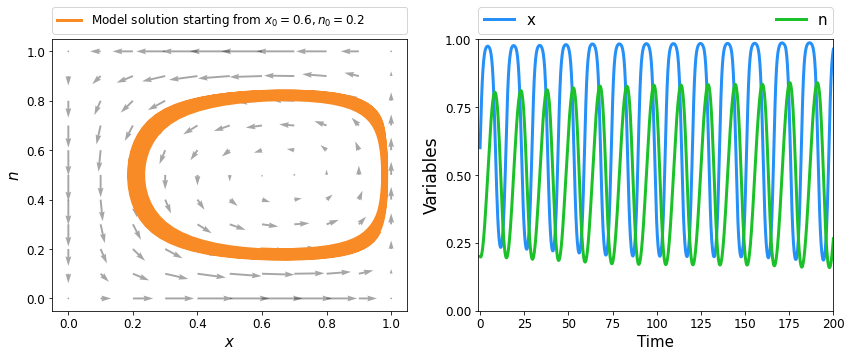

In [37]:
make_graphs(model=solution,
            save=False, directory='/home/user/Desktop/',
            fig_name='game.png')